In [1]:
import warnings
warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind,wilcoxon,ranksums

In [2]:
with open("pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl", "rb") as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df["pid"].unique())
# subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df["pid"].isin(subj_list)]

In [3]:
K = 6
D = 10
N = 85
num_subjs = 92
M = 20
num_resamples = 500

In [4]:
# from sklearn.cluster import KMeans
# from munkres import Munkres
# from sklearn.metrics.pairwise import cosine_similarity


# def reference_comms(num_states, X):
#     X = np.concatenate(X, axis=-1)
#     kmeans = KMeans(
#         n_clusters=num_states, init="k-means++", n_init=50, random_state=74
#     ).fit(X=X.T)
#     print("found reference")
#     return kmeans.cluster_centers_.T  # num_rois x num_comms


# def align_two_partitions(source_comms, target_comms):
#     # align source onto target

#     # distatnce matrix
#     Dd = 1 - cosine_similarity(target_comms.T, source_comms.T)
#     # Hungarian permutation method
#     best_pi = list(zip(*Munkres().compute(Dd)))[1]
#     source_comms = source_comms[:, best_pi]
#     return source_comms, best_pi


# def align_partitions(num_states, X):
#     comm_cntrs = reference_comms(num_states, X)
#     with open(f'pkl/rslds_state_attractors_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','wb') as f:
#         pickle.dump(comm_cntrs,f)
#     best_pis = []
#     for idx, comms in tqdm(enumerate(X)):
#         _, best_pi = align_two_partitions(source_comms=comms, target_comms=comm_cntrs)
#         best_pis.append(best_pi)
#     return best_pis


# def get_attractors(idx_resample):
#     # if idx_resample<=100:
#     #     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
#     #         model,_,_,_ = pickle.load(f)
#     # elif idx_resample>100:
#     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_M{M}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
#         model,_,_,_ = pickle.load(f)
#     As = model.dynamics.As
#     bs = model.dynamics.bs
#     C = model.emissions.Cs[0]
#     d = model.emissions.ds[0]
#     attractors = np.zeros((K, N))
#     for k in range(K):
#         attractors[k, :] = C @ (np.linalg.inv(np.eye(D) - As[k]) @ bs[k]) + d
#     attractors /= np.expand_dims(np.linalg.norm(attractors, axis=1), axis=1)
#     return attractors.T


# all_attractors = []
# for idx_resample in tqdm(range(1, 1 + num_resamples)):
#     all_attractors.append(get_attractors(idx_resample))

# all_perms = align_partitions(K, all_attractors)

In [5]:
def get_df(idx_resample, perm):
    # if idx_resample<=100:
    #     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
    #         model, q, elbos, resampled_subj_list = pickle.load(f)
    # elif idx_resample>100:
    #     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_M{M}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
    #         model, q, elbos, resampled_subj_list = pickle.load(f)    
    with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_M{M}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
        model, q, elbos, resampled_subj_list = pickle.load(f)    
        
    model.permute(perm)
    # model.permute(np.array([0, 1, 3, 2, 4, 5]))
    # model.permute(np.array([1,2,4,3,5,0])) #300 resamples
    # model.permute(np.array([2,4,3,0,1,5])) #400 resamples
    # model.permute(np.array([1,0,2,3,4,5])) #500 resamples
    # model.permute(np.array([1,0,4,2,3,5])) #200 resamples input5
    # model.permute(np.array([2,3,0,4,5,1])) #200 resamples input15

    resampled_df = []
    for pid in resampled_subj_list:
        resampled_df.append(orig_df[orig_df["pid"] == pid])
    resampled_df = pd.concat(resampled_df).reset_index().drop("index", axis=1)
    df = resampled_df

    df["continuous_states"] = [None] * df.shape[0]
    df["discrete_states"] = [None] * df.shape[0]
    hrflag = 0
    prox_bins = list(np.arange(M // 2) / (M // 2))[1:]
    dir_bins = [0]
    nprox = len(prox_bins) + 1
    ndir = len(dir_bins) + 1
    for idx_row in range(df.shape[0]):
        prox = df.loc[idx_row]["proximity"]
        prox = prox - prox.min()
        prox = prox / prox.max()
        proxd = np.digitize(prox, bins=prox_bins)
        dird = 1 - np.digitize(df.loc[idx_row]["direction"], bins=dir_bins)
        stim_category = (nprox * ndir - 1) * dird + ((-1) ** dird) * proxd
        input = np.roll(np.eye(nprox * ndir)[stim_category], shift=hrflag, axis=0)

        y = df.loc[idx_row]["timeseries"]
        x = q.mean_continuous_states[idx_row]
        z = model.most_likely_states(x, y, input=input)
        df.at[idx_row, "continuous_states"] = x
        df.at[idx_row, "discrete_states"] = z
        prox = df.loc[idx_row]["proximity"]
        prox = prox - prox.min()
        prox = prox / prox.max()
        df.at[idx_row, "proximity"] = prox

    return df,model

In [6]:
prox_bins = list(np.arange(M // 2) / (M // 2))[1:]
dir_bins = [0]
nprox = len(prox_bins) + 1
ndir = len(dir_bins) + 1
hrf_shift = 3


def get_p_state_giv_stimulus(df, shuffle_z: bool = False):

    zs = []
    stims = []
    for idx_row in range(df.shape[0]):
        z = np.copy(df.loc[idx_row]["discrete_states"])  # sequence of discrete states

        # if shuffle_z is True: np.random.shuffle(z)
        if shuffle_z:
            z = np.roll(z, shift=np.random.randint(z.shape[0]))

        # bin proximity and direction values
        prox = np.digitize(df.loc[idx_row]["proximity"], bins=prox_bins)
        dir = 1 - np.digitize(df.loc[idx_row]["direction"], bins=dir_bins)

        # take care of hrf lag
        if hrf_shift > 0:
            prox = np.roll(prox, shift=hrf_shift)[hrf_shift:]
            dir = np.roll(dir, shift=hrf_shift)[hrf_shift:]
            z = z[hrf_shift:]

        # make sure lengths are consistent
        assert len(z) == len(prox)
        assert len(z) == len(dir)

        stim = (nprox * ndir - 1) * dir + ((-1) ** dir) * prox
        stims.append(stim)
        zs.append(z)

    zs = np.hstack(zs)
    stims = np.hstack(stims)

    # calculate marginals
    prob_mat = np.zeros((K, nprox * ndir))
    for idx_state in range(K):
        for idx_stim in range(nprox * ndir):
            prob_mat[idx_state, idx_stim] = np.sum(
                (zs == idx_state) * (stims == idx_stim)
            ) / np.sum(stims == idx_stim)
    # prob_mat = prob_mat / prob_mat.sum()

    return prob_mat

def get_p_state(df):
    zs = np.hstack(list(df['discrete_states'].values))
    p_state = np.zeros(K)
    for k in range(K):
        p_state[k] = (zs==k).sum()/zs.shape[0]
    return p_state

In [7]:
# all_dfs = {}
# all_models = {}
# for idx_resample in tqdm(range(1,num_resamples+1)):
#     all_dfs[idx_resample],all_models[idx_resample] = get_df(idx_resample,np.array(all_perms[idx_resample-1]))


In [8]:
with open(f'pkl/all_dfs_models_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    all_dfs,all_models = pickle.load(f)

In [9]:
true_count_mats = {}
null_count_mats = []
state_masks = {}
for idx_resample in tqdm(range(1, num_resamples + 1)):
    true_count_mat = get_p_state_giv_stimulus(all_dfs[idx_resample], shuffle_z=False)
    p_state = get_p_state(all_dfs[idx_resample])
    state_mask = np.zeros(K)
    for idx_state in range(K):
        # if true_count_mat[idx_state, :].sum() < 1:
        if p_state[idx_state] < 0.1:
            state_mask[idx_state] = 1
            true_count_mat[idx_state, :] = np.nan

    state_masks[idx_resample] = state_mask
    # if state_mask.sum()>2: continue
    true_count_mats[idx_resample] = true_count_mat

    for _ in range(1):
        null_count_mat = get_p_state_giv_stimulus(all_dfs[idx_resample], shuffle_z=True)

        for idx_state in range(K):
            if state_mask[idx_state] == 1:
                null_count_mat[idx_state, :] = np.nan

        null_count_mats.append(null_count_mat)

100%|██████████| 500/500 [05:27<00:00,  1.53it/s]


In [10]:
# with open(f"pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl", "wb") as f:
#     pickle.dump(state_masks, f)

In [11]:
true_P = np.stack(true_count_mats.values(), axis=0)
null_P = np.stack(null_count_mats, axis=0)
pvals = np.zeros(true_P.shape[1:])
for idx_state in range(K):
    for idx_stim in range(nprox * ndir):
        true_vals = true_P[:, idx_state, idx_stim]
        null_vals = null_P[:, idx_state, idx_stim]
        true_vals = true_vals[~np.isnan(true_vals)]
        null_vals = null_vals[~np.isnan(null_vals)]
        pvals[idx_state, idx_stim] = wilcoxon(
            true_vals,
            null_vals,
            # equal_var=False,
            alternative="greater",
        ).pvalue

In [12]:
# true_P = true_P[:,[5, 0, 1, 3, 2, 4],:]
# pvals = pvals[[5, 0, 1, 3, 2, 4],:]

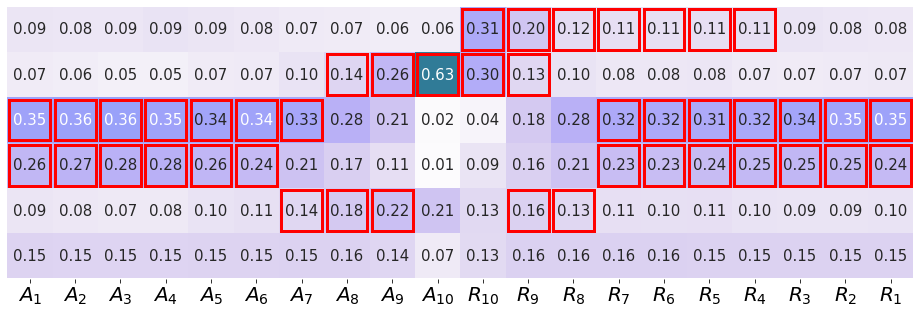

In [13]:
import cmasher as cmr

xticklabels = [None] * nprox * ndir
dir = "AR"
for i in [0, 1]:
    for j, prox in enumerate(prox_bins + [1]):
        xticklabels[(nprox * ndir - 1) * i + ((-1) ** i) * j] = f"${dir[i]}_"+"{"+f"{j+1}"+"}$"

mean_P = np.nanmean(true_P, axis=0)
# mean_P = mean_P[:5,:]
mean_P /= np.expand_dims(mean_P.sum(axis=0), axis=0)

# mean_P = mean_P/np.expand_dims(np.sum(mean_P,axis=0),axis=0)
# pvals = pvals[:5,:]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,5), sharex=True)
sns.heatmap(
    mean_P,
    annot=mean_P,
    fmt=".2f",
    annot_kws={"size": 15},
    cmap=cmr.horizon_r,  # "gist_earth",
    vmin=0,
    vmax=1,
    ax=ax,
    cbar=False,
    square=True,
)
for i in range(K-1):
    for j in range(nprox * ndir):
        if pvals[i, j] < 0.05 / (nprox * ndir * K):
            ax.add_patch(
                # patches.Circle((j+0.5,i+0.5),0.47,linewidth=2, edgecolor='red',facecolor='none')
                patches.Rectangle(
                    (j + 0.05, i + 0.05),
                    width=0.9,
                    height=0.9,
                    linewidth=3,
                    edgecolor="red",
                    facecolor="none",
                )
            )
        # elif pvals[i,j] < 0.05:
        #     ax.add_patch(
        #         # patches.Circle((j+0.5,i+0.5),0.47,linewidth=2, edgecolor='red',facecolor='none')
        #         patches.Rectangle((j+0.05,i+0.05),width=0.9,height=0.9,linewidth=3, edgecolor='orange',facecolor='none')
        #     )

# ax.set_title(r"P(State|Stimulus)".format(idx_state=idx_state), fontsize=20)
# _ = ax.set_yticklabels(
#     [f"State{i}" for i in [1, 2, 3, 4, 5, 6]], fontsize=20, rotation=0
# )
_ = ax.set_yticks([])
_ = ax.set_xticklabels(xticklabels, fontsize=20, rotation=0)
# _ = ax.set_xlabel("Stimulus category", fontsize=20)
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=15)
# cbar.ax.set_yticks(np.arange(6) / 5)
# cbar.ax.set_position([0.755, 0.15, 0.5, 0.7])
fig.savefig(
    f"figures/fig_P_state_given_stim_K{K}_D{D}_M{M}.eps", dpi=600, bbox_inches="tight"
)

In [14]:
def bootstrap_err(sample):
    means = np.zeros(100)
    for i in range(100):
        means[i] = np.random.choice(sample,len(sample),replace=True).mean()
    return means.std()*3

def get_lb_ub(null_P):
    err_P = np.zeros_like(null_P[0])
    mean_null_P = np.zeros_like(null_P[0])
    for idx_state in range(null_P.shape[1]):
        for idx_stim in range(nprox * ndir):
            null_vals = null_P[:, idx_state, idx_stim]
            null_vals = null_vals[~np.isnan(null_vals)]
            err_P[idx_state, idx_stim] = bootstrap_err(null_vals)
            mean_null_P[idx_state, idx_stim] = np.mean(null_vals)
    return mean_null_P-err_P, mean_null_P+err_P

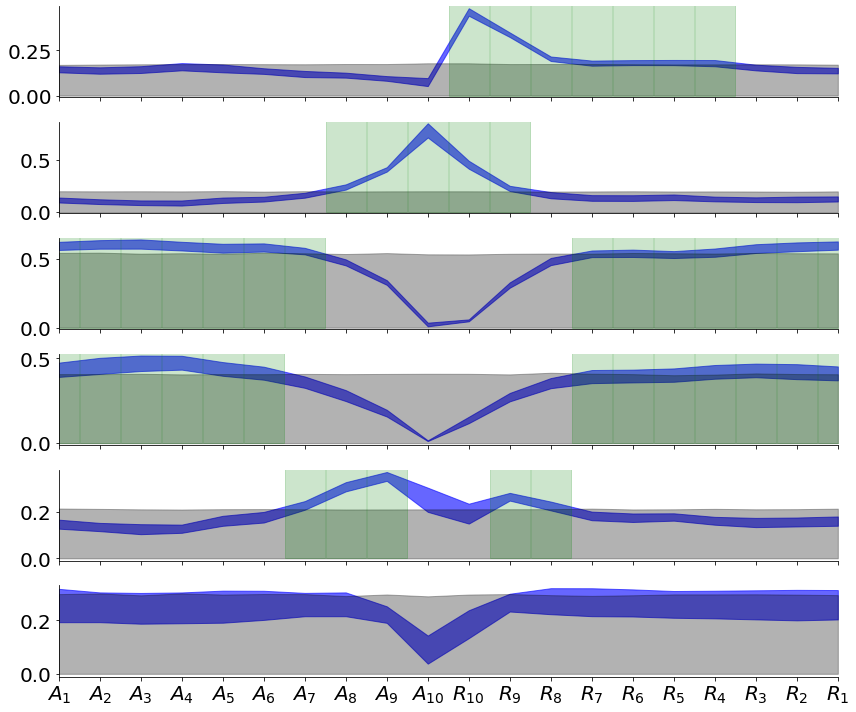

In [15]:
lb_null, ub_null = get_lb_ub(null_P)
lb_true, ub_true = get_lb_ub(true_P)

fig,axs = plt.subplots(nrows=K, ncols=1, figsize=(12,10), sharex=True, sharey=False)

for idx_state in range(K):
    ax = axs[idx_state]
    ax.fill_between(np.arange(nprox*ndir), lb_true[idx_state], ub_true[idx_state],color='b',alpha=0.6)
    ax.fill_between(np.arange(nprox*ndir), 0*lb_null[idx_state], ub_null[idx_state],color='k',alpha=0.3)
    _ = ax.set_xticks(np.arange(nprox*ndir))
    _ = ax.set_xticklabels(xticklabels, fontsize=20, rotation=0)
    ax.tick_params(axis='y',labelsize=20)
    ax.set_ylim([0-0.01,np.max(ub_true[idx_state]+0.01)])
    ax.spines[['right','top']].set_visible(False)
    tick_labels = ax.get_xticklabels()
    for j in range(nprox * ndir):
        if idx_state<K-1 and pvals[idx_state, j] < 0.05 / (nprox * ndir * K):
            pass
            ax.fill_between([j-0.49,j+0.49], [0,0], [1]*2,color='g',alpha=0.2)
            # tick_labels[j].set_color("r")
            # tick_labels[j].set_fontweight("bold")
    # ax.xaxis.grid(True)
    ax.set_xlim([0,19])
    
fig.tight_layout()

fig.savefig(
    f"figures/new_fig_P_state_given_stim_K{K}_D{D}_M{M}_poster.jpg", dpi=600, bbox_inches="tight"
)

20
20
20
20
20


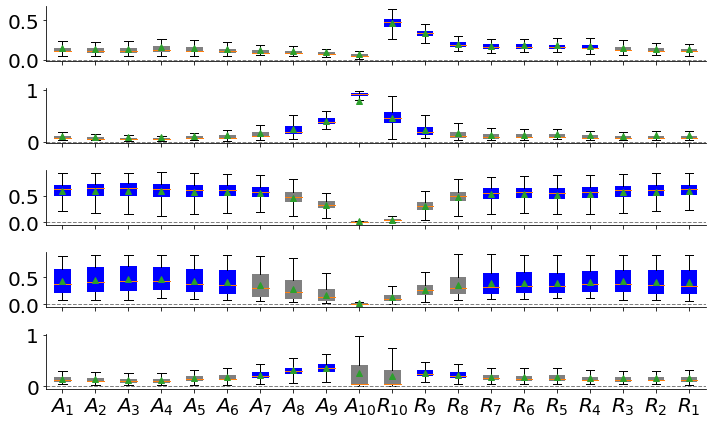

In [19]:
fig,axs = plt.subplots(nrows=K-1, ncols=1, figsize=(10,6), sharex=True)
for idx_state in range(K-1):
    prob_values = []
    for idx_stim in range(M):
        vals = true_P[:,idx_state,idx_stim]
        prob_values.append(vals[~np.isnan(vals)])
    print(len(prob_values))
    ax = axs[idx_state]
    boxprops = dict(linestyle='-', linewidth=0, color='k')
    bplot = ax.boxplot(prob_values, showfliers=False, patch_artist=True, boxprops=boxprops, showmeans=True)
    _ = ax.set_xticks(1+np.arange(nprox*ndir))
    _ = ax.set_xticklabels(xticklabels, fontsize=20, rotation=0)
    ax.tick_params(axis='y',labelsize=20)
    # ax.set_ylim([0-0.01,np.max(ub_true[idx_state]+0.01)])
    ax.spines[['right','top']].set_visible(False)
    ax.axhline(0,linestyle='--',linewidth=1,color='grey')

    for idx_stim in range(nprox*ndir):
        if pvals[idx_state,idx_stim]<0.05/(K*nprox*ndir):
    #         if mean_orient_mat1[idx_state,idx_stim]>0:
            # ax.get_xticklabels()[idx_stim].set_color("b")
            bplot['boxes'][idx_stim].set_facecolor("b")
        else:
            # ax.get_xticklabels()[idx_stim].set_color("grey")
            bplot['boxes'][idx_stim].set_facecolor("grey")
    #     else:
    #         bplot['boxes'][idx_stim].set_facecolor("grey")



fig.tight_layout()
fig.savefig(
    f"figures/new_fig_P_state_given_stim_K{K}_D{D}_M{M}_poster.jpg", dpi=600, bbox_inches="tight"
)

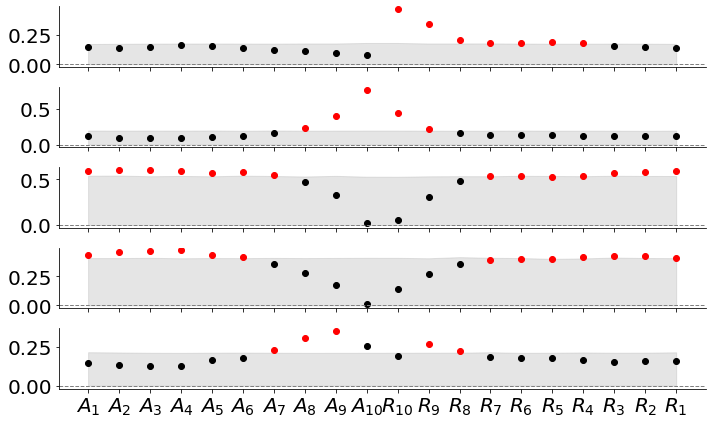

In [36]:

fig,axs = plt.subplots(nrows=K-1, ncols=1, figsize=(10,6), sharex=True)
for idx_state in range(K-1):
    prob_values = []
    for idx_stim in range(M):
        vals = true_P[:,idx_state,idx_stim]
        prob_values.append(vals[~np.isnan(vals)])
    
    prob_values = [i.mean() for i in prob_values]
    
    ax = axs[idx_state]
    ax.fill_between(1+np.arange(nprox*ndir),0*lb_null[idx_state],ub_null[idx_state],color='grey',alpha=0.2)
    _ = ax.set_xticks(1+np.arange(nprox*ndir))
    _ = ax.set_xticklabels(xticklabels, fontsize=20, rotation=0)
    ax.tick_params(axis='y',labelsize=20)
    # ax.set_ylim([0-0.01,np.max(ub_true[idx_state]+0.01)])
    ax.spines[['right','top']].set_visible(False)
    ax.axhline(0,linestyle='--',linewidth=1,color='grey')

    for idx_stim in range(nprox*ndir):
        if pvals[idx_state,idx_stim]<0.05/(K*nprox*ndir):
            ax.scatter(1+idx_stim,prob_values[idx_stim],color='r')
        else:
            ax.scatter(1+idx_stim,prob_values[idx_stim],color='k')



fig.tight_layout()
fig.savefig(
    f"figures/new_fig_P_state_given_stim_K{K}_D{D}_M{M}_ppt.jpg", dpi=600, bbox_inches="tight"
)

In [17]:
with open(f'pkl/all_dfs_models_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','wb') as f:
    pickle.dump([all_dfs,all_models],f)

(array([19., 28., 14., 19., 23., 12.,  8.,  7.,  6.,  2.]),
 array([0.06744818, 0.12203236, 0.17661654, 0.23120071, 0.28578489,
        0.34036906, 0.39495324, 0.44953742, 0.50412159, 0.55870577,
        0.61328995]),
 <BarContainer object of 10 artists>)

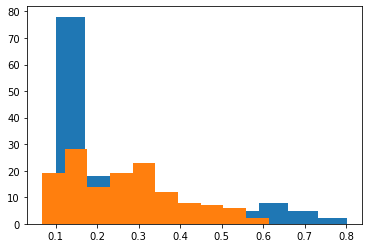

In [18]:
plt.hist(null_P[:, 5, 11])
plt.hist(true_P[:, 5, 11])